In [1]:
pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 646.0 kB/s eta 0:00:00


100%|██████████| 791918971/791918971 [00:24<00:00, 32182184.15it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 15107737.79it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet
Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: .


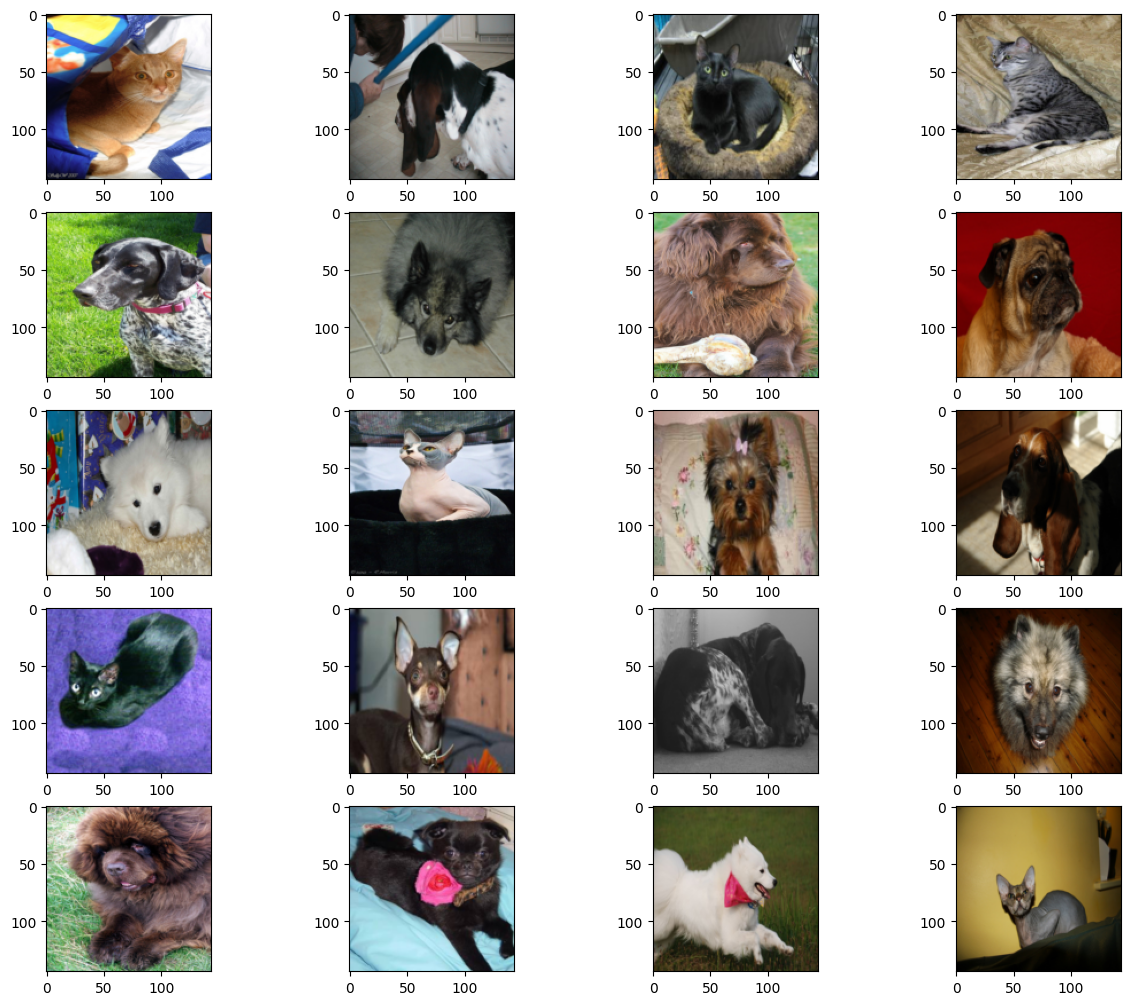

In [2]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((144,144)), ToTensor()]

class Compose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image, target):
    for t in self.transforms:
      image = t(image)
    return image, target

def show_images(images, num_samples=20, cols=4):
  plt.figure(figsize=(15,15))
  idx = int(len(dataset)/num_samples)
  print(images)
  for i, img in enumerate(images):
    if i%idx == 0:
      plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx)  + 1)
      plt.imshow(to_pil_image(img[0]))

dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(dataset)

In [3]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2= patch_size),
        nn.Linear(patch_size * patch_size * in_channels, emb_size)
    )

  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x

sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print('Initial shape:', sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print('Patches shape:', embedding.shape)

Initial shape: torch.Size([1, 3, 144, 144])
Patches shape: torch.Size([1, 324, 128])


In [4]:
from einops import rearrange

class Attention(nn.Module):
  def __init__(self, dim, n_heads, dropout):
    super().__init__()
    self.n_heads = n_heads
    self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                           num_heads=n_heads,
                                           dropout=dropout)
    self.q = torch.nn.Linear(dim, dim)
    self.k = torch.nn.Linear(dim, dim)
    self.v = torch.nn.Linear(dim, dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attn_op, att_op_weights = self.att(q, k, v)
    return attn_op



In [ ]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1,5,128))).shape

torch.Size([1, 5, 128])

In [5]:
class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn = fn
  def forward(self, x, **kwargs):
    return self.fn(self.norm(x), **kwargs)

In [6]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1,5,128))).shape

torch.Size([1, 5, 128])

In [7]:
class FeedForward(nn.Sequential):
  def __init__(self, dim, hidden_dim, dropout = 0.):
    super().__init__(
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim),
        nn.Dropout(dropout)
    )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1,5,128))).shape

torch.Size([1, 5, 128])

In [8]:
class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x += res
    return x

In [9]:
residual_net = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_net(torch.ones((1,5,128))).shape

torch.Size([1, 5, 128])

In [17]:
from einops import repeat

class ViT(nn.Module):
  def __init__(self, ch=3, img_size=144, patch_size=8, emb_dim=32,
               n_layers=4, out_dim=37, dropout=0.1, heads=2):
    super().__init__()
    self.channels= ch
    self.height = img_size
    self.width = img_size
    self.patch_size = patch_size
    self.n_layers = n_layers

    self.patch_embedding = PatchEmbedding(in_channels=ch, patch_size=patch_size, emb_size=emb_dim)

    num_patches = (img_size // patch_size) ** 2
    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.rand(1,1, emb_dim))

    self.layers = nn.ModuleList([])
    for _ in range(n_layers):
      transformer_block = nn.Sequential(
          ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads= heads, dropout=dropout))),
          ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout= dropout)))
      )
      self.layers.append(transformer_block)

      self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))

  def forward(self, img):
    x = self.patch_embedding(img)
    b, n, _ = x.shape

    cls_token = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
    x = torch.cat((cls_token, x), dim=1)
    x+= self.pos_embedding[:, :(n + 1)]

    for i in range(self.n_layers):
      x = self.layers[i](x)

    return self.head(x[:, 0, :])

model = ViT()
model(torch.ones((1,3,144,144)))

tensor([[-0.5429, -0.6629, -0.8704, -0.3044,  0.6746,  0.6639,  0.3899, -0.4956,
          0.2637, -0.2406, -0.9115,  0.0873,  0.8770,  0.4373, -0.2981,  0.9590,
         -0.7921, -0.1212,  0.6810, -0.4056,  0.3973,  0.4337,  0.0356,  1.0695,
          0.6036,  0.3213,  0.8142, -0.7370, -0.0891,  0.3790,  0.3694, -0.5232,
          0.3633,  0.3730,  0.1632,  0.6705, -0.1885]],
       grad_fn=<AddmmBackward0>)

In [19]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(len(dataset) * 0.8)
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [26]:
import torch.optim as optim
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViT().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1000):
  epoch_loss = []
  model.train()
  for step, (inputs,labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.item())

  if epoch%5 == 0:
    print(f">>> Epoch {epoch} loss:", np.mean(epoch_loss))
    epoch_losses = []

    for step, (inputs, labels) in enumerate(test_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      epoch_losses.append(loss.item())
    print(f">>> Epoch {epoch} Test loss:", np.mean(epoch_losses))

KeyboardInterrupt: 

In [27]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print('predicted class', outputs,argmax(-1))
print('actual class',labels)

NameError: name 'argmax' is not defined